# Plotly Interactive Plots

Some interactive plots to visualize the dataset with more details.

In case you are using a binder to run the examples, you need to install the plotly jupyter lab extension:

```bash
pip install jupyterlab "ipywidgets>=7.5"
jupyter labextension install jupyterlab-plotly@4.8.1
jupyter labextension install @jupyter-widgets/jupyterlab-manager plotlywidget@4.8.1
```
or follow the [latest documentation](https://github.com/plotly/plotly.py#jupyterlab-support-python-35).

In [1]:
# imports

%load_ext autoreload
%autoreload 2

import math

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# plotly imports
from plotly.subplots import make_subplots
import plotly.graph_objs as go

from tqdm import tqdm
tqdm.pandas()

In [2]:
# Test API function before running larger simulations
from sim_trace import generate_trace_api

input_data = {
    "arrival_rate": 0.9, 
    "warm_service_rate": 1/2.016, 
    "cold_service_rate": 1/2.163,
    "expiration_threshold": 600, 
    "max_time": 1e5,
}

generate_trace_api(input_data)

{'reqs_cold': 118,
 'reqs_total': 90041,
 'reqs_warm': 89923,
 'prob_cold': 0.0013105140991326173,
 'reqs_reject': 0,
 'prob_reject': 0.0,
 'lifespan_avg': 6652.110691321929,
 'inst_count_avg': 7.67989628840567,
 'inst_running_count_avg': 1.814875997770198,
 'inst_idle_count_avg': 5.865020290635472,
 'arrival_rate': 0.9,
 'warm_service_rate': 0.49603174603174605,
 'cold_service_rate': 0.46232085067036527,
 'expiration_threshold': 600,
 'max_time': 100000.0}

In [3]:
from simfaas.ServerlessSimulator import ServerlessSimulator

getArrayIdxArr = lambda x, idx: np.array(x)[idx]
def sample_sim_history_idxs(sim, num_of_points=200):
    hist_idx = 0
    # go in 10 second steps
    hist_step = sim.max_time / num_of_points
    idxs = [0]
    last_hist_time = 0
    while hist_idx < (len(sim.hist_times) - 1):
        hist_idx += 1
        if sim.hist_times[hist_idx] - last_hist_time < hist_step:
            continue

        last_hist_time = sim.hist_times[hist_idx]
        idxs.append(hist_idx)
    return idxs


# generate the trace
sim = ServerlessSimulator(**input_data)
sim.generate_trace(debug_print=False, progress=False)
# analyze the trace for plot
idxs = sample_sim_history_idxs(sim)
sampled_hist_times = getArrayIdxArr(sim.hist_times, idxs)
sampled_hist_inst_counts = getArrayIdxArr(sim.hist_server_count, idxs)
# calculate sampled instance count average so far
sampled_hist_inst_avgs = np.cumsum(sampled_hist_inst_counts) / np.array(list(range(len(sampled_hist_inst_counts))))

In [4]:
fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x = [i/60 for i in sampled_hist_times],
        y = sampled_hist_inst_counts,
        mode = 'markers+lines',
        name = "Current Value",
    ),
)
fig.add_trace(
    go.Scatter(
        x = [i/60 for i in sampled_hist_times],
        y = sampled_hist_inst_avgs,
        mode = 'markers+lines',
        name = "Average Estimate",
    ),
)
fig.update_layout(title="Instance Counts Over Time", xaxis=dict(title="Time (minutes)"), yaxis=dict(title="Instance Count"))

In [5]:
inst_count_avg_estimates = []
for _ in tqdm(range(10)):
    # generate the trace
    sim = ServerlessSimulator(**input_data)
    sim.generate_trace(debug_print=False, progress=False)
    # analyze the trace for plot
    idxs = sample_sim_history_idxs(sim, num_of_points=20)
    sampled_hist_times = getArrayIdxArr(sim.hist_times, idxs)
    sampled_hist_inst_counts = getArrayIdxArr(sim.hist_server_count, idxs)
    # calculate sampled instance count average so far
    sampled_hist_inst_avgs = np.cumsum(sampled_hist_inst_counts) / np.array(list(range(len(sampled_hist_inst_counts))))
    inst_count_avg_estimates.append({
        'x': [i/60 for i in sampled_hist_times],
        'y': list(sampled_hist_inst_avgs)
    })

100%|██████████| 10/10 [00:46<00:00,  4.66s/it]


In [6]:
fig = go.Figure()
for inst_count_avg_estimate in inst_count_avg_estimates:
    fig.add_trace(
        go.Scatter(
            x = inst_count_avg_estimate['x'],
            y = inst_count_avg_estimate['y'],
            mode = 'markers+lines',
            # name = "Average Estimate",
        ),
    )
fig.update_layout(title="Instance Counts Over Time", xaxis=dict(title="Time (minutes)"), yaxis=dict(title="Instance Count Average Estimate"))

fig.update_yaxes(range=[
    math.floor(min([min(i['y'][1:]) for i in inst_count_avg_estimates]) * 0.8), 
    math.ceil(max([max(i['y'][1:]) for i in inst_count_avg_estimates]) * 1.1)
    ])

## Make The Interactive Overall Plots

In [7]:
# Plot characteristics for different arrival rates and expiration thresholds
num_arrival_rates = 10
exp_thresholds = [10, 60, 600, 1200, 1800]
exp_threshold_labels = ["10 sec", "1 min", "10 min", "20 min", "30 min"]
input_data['arrival_rate'] = list(np.repeat(np.logspace(-3,1,num_arrival_rates), len(exp_thresholds)))
input_data['expiration_threshold'] = exp_thresholds * num_arrival_rates
input_data['expiration_threshold_labels'] = exp_threshold_labels * num_arrival_rates

df = pd.DataFrame(data=input_data).reset_index(drop=True)

def generate_trace_apply(x):
    return pd.Series(generate_trace_api(x.to_dict()))

df = df.progress_apply(generate_trace_apply, axis=1)
df.tail()

100%|██████████| 50/50 [10:20<00:00, 12.40s/it]


,reqs_cold,reqs_total,reqs_warm,prob_cold,reqs_reject,prob_reject,lifespan_avg,inst_count_avg,inst_running_count_avg,inst_idle_count_avg,arrival_rate,warm_service_rate,cold_service_rate,expiration_threshold,max_time,expiration_threshold_labels
45,23752,997238,973486,0.023818,0,0.0,120.734719,28.654768,20.135436,8.519332,10.0,0.496032,0.462321,10,100000.0,10 sec
46,3667,1000352,996685,0.003666,0,0.0,906.854509,33.123974,20.191473,12.932501,10.0,0.496032,0.462321,60,100000.0,1 min
47,338,999651,999313,0.000338,0,0.0,11735.433485,37.660413,20.112313,17.548100,10.0,0.496032,0.462321,600,100000.0,10 min
48,149,1000576,1000427,0.000149,0,0.0,28401.077890,38.521834,20.132414,18.389420,10.0,0.496032,0.462321,1200,100000.0,20 min
49,137,1000943,1000806,0.000137,0,0.0,29962.003994,39.557215,20.169117,19.388098,10.0,0.496032,0.462321,1800,100000.0,30 min


In [8]:
# calculate utilizations
df['utilization_percent'] = df['inst_running_count_avg'] / df['inst_count_avg'] * 100
df['prob_cold_percent'] = df['prob_cold'] * 100

## Interactive Plots

We will be making interactive plots here using the data generated by our simulator.

In [9]:
# simple interactive plot

# create a dataframe for each expiration threshold
dfs = [df.loc[df['expiration_threshold_labels'] == name, :] for name in exp_threshold_labels]

# create traces
def df_add_trace(col_name, col_label, fig, axis_titles):
    for idx in range(len(exp_threshold_labels)):
        fig.add_trace(
            go.Scatter(
                x = dfs[idx].loc[:,'arrival_rate'],
                y = dfs[idx].loc[:,col_name],
                mode = 'markers+lines',
                name = exp_threshold_labels[idx],
            ),
        )

        axis_postfix = ""
        axis_titles["xaxis" + axis_postfix] = dict(title="Arrival Rate (reqs/sec)")
        axis_titles["yaxis" + axis_postfix] = dict(title=col_label)

    return axis_titles


def plot_fig_for_col(col_name, col_label):
    fig = go.Figure()
    axis_titles = {}
    axis_titles = df_add_trace(col_name, col_label, fig, axis_titles)
    fig.update_layout(
        xaxis_type="log",
        **axis_titles
        )
    fig.show()

In [10]:
plot_fig_for_col('prob_cold_percent', 'Prob of Cold Start (%)')

In [11]:
plot_fig_for_col('utilization_percent', 'Utilization (%)')

In [12]:
plot_fig_for_col('inst_idle_count_avg', 'Average Idle Instances')

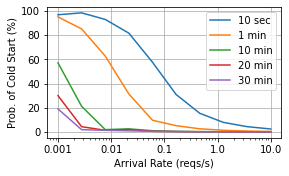

In [20]:
# plot one for validation, and for the paper
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

def tick_formatter(x, pos):
    if x > 0.01:
        return f"{x:.1f}"
    elif x > 0.001:
        return f"{x:.2f}"
    else:
        return f"{x:.3f}"

formatter = FuncFormatter(tick_formatter)

col_name = "prob_cold_percent"

plt.figure(figsize=(4,2.4))
for idx in range(len(exp_threshold_labels)):
    plt.semilogx(dfs[idx].loc[:,'arrival_rate'], dfs[idx].loc[:,col_name], label=exp_threshold_labels[idx])

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.ylabel("Prob. of Cold Start (%)")
plt.xlabel('Arrival Rate (reqs/s)')
plt.gca().xaxis.set_major_formatter(formatter)
plt.gcf().subplots_adjust(left=0.15, bottom=0.18)

plt.savefig("figs/05-example-what-if.pdf")